In [3]:
import cv2
import matplotlib.image as mplib 
from PIL import Image
import numpy as np
classes = ["epithelial","fibroblast","inflammatory","others"]
def load_data(labelNames, root):    
    images = list()
    labels = list()
    
    for label in labelNames:
        # get image directory
        img_dir = os.path.join(root, f"{label}")
        
        for img in os.listdir(img_dir):
            img = np.array(Image.open(os.path.join(img_dir, img),'r'))
            images.append(img)
            labels.append(label)
        
    return (images, labels)
multiclass_path = "Image_classification_data/multi-task"
images, labels = load_data(classes, multiclass_path)
images = np.asarray(images)
labels = np.asarray(labels)
print(images.shape)
print(labels.shape)

(9896, 27, 27, 3)
(9896,)


## Split dataset into 3

In [38]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)
print(f"Train {x_train.shape}\n Validation {x_val.shape} \n Test {x_test.shape}")

Train (5937, 27, 27, 3)
 Validation (1979, 27, 27, 3) 
 Test (1980, 27, 27, 3)


In [15]:
from sklearn.preprocessing import LabelEncoder
def label_encoder(arr):
    labels = np.array(arr)
    label_coder = LabelEncoder()
    return label_coder.fit_transform(labels)

In [30]:
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)
y_val = label_encoder(y_val)

In [40]:
no_classes = 4
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(label_encoder(y_train), no_classes)
y_val = to_categorical(label_encoder(y_val), no_classes)
y_test = to_categorical(label_encoder(y_test), no_classes)

# Model 1

In [190]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, InputLayer, MaxPooling2D, Dropout, Rescaling
from keras.applications import xception
from keras.metrics import Precision
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
no_classes = 4
input_shape = (27,27,3)
model = Sequential([
    Rescaling(1./255),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'),
    Flatten(),
Dense(64, activation='relu'),
Dropout(0.4),
Dense(64, activation='relu'),
Dropout(0.4),
Dense(no_classes, activation="softmax")
])
model.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=[CategoricalAccuracy(), Precision()])
  

In [191]:
model.build(x_train.shape)
model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_54 (Rescaling)    (5937, 27, 27, 3)         0         
                                                                 
 conv2d_159 (Conv2D)         (5937, 27, 27, 32)        896       
                                                                 
 conv2d_160 (Conv2D)         (5937, 27, 27, 16)        4624      
                                                                 
 max_pooling2d_93 (MaxPoolin  (5937, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 flatten_53 (Flatten)        (5937, 2704)              0         
                                                                 
 dense_152 (Dense)           (5937, 64)                173120    
                                                     

In [193]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=40
)

Epoch 1/40
186/186 [==============================] - 16s 84ms/step - loss: 1.0633 - categorical_accuracy: 0.5742 - precision_52: 0.7452 - val_loss: 0.8658 - val_categorical_accuracy: 0.6756 - val_precision_52: 0.7918
Epoch 2/40
186/186 [==============================] - 13s 67ms/step - loss: 0.9142 - categorical_accuracy: 0.6539 - precision_52: 0.7541 - val_loss: 0.8794 - val_categorical_accuracy: 0.6407 - val_precision_52: 0.7048
Epoch 3/40
186/186 [==============================] - 10s 55ms/step - loss: 0.8462 - categorical_accuracy: 0.6780 - precision_52: 0.7681 - val_loss: 0.7635 - val_categorical_accuracy: 0.6958 - val_precision_52: 0.7810
Epoch 4/40
186/186 [==============================] - 12s 66ms/step - loss: 0.7824 - categorical_accuracy: 0.7064 - precision_52: 0.7820 - val_loss: 0.7277 - val_categorical_accuracy: 0.7221 - val_precision_52: 0.7751
Epoch 5/40
186/186 [==============================] - 14s 73ms/step - loss: 0.7866 - categorical_accuracy: 0.7047 - precision_52

# Model 2

In [182]:
from keras.metrics import CategoricalAccuracy
from keras.layers import BatchNormalization, ReLU
no_classes = 4
input_shape = (27,27,3)
model = Sequential([
    Rescaling(1./255),
    Conv2D(8, 1,padding='same', activation=ReLU()),
    Conv2D(8, 1, activation=ReLU()),
    MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'),

    Conv2D(32, 5,padding='same', activation=ReLU()),
    MaxPooling2D(pool_size=(3,3),strides=1,padding = 'valid'),

    Conv2D(32, 3, activation='relu', strides=1),
    MaxPooling2D(pool_size=(3,3),strides=2,padding = 'valid'),
    
    Flatten(),
Dense(256, activation='relu'),
Dropout(0.4),
Dense(128, activation='relu'),
Dropout(0.4),
Dense(64, activation='relu'),
Dense(no_classes, activation="softmax")
])
model.compile(
  optimizer='adam',
  loss=CategoricalCrossentropy(),
  metrics=[CategoricalAccuracy(), Precision()])

In [183]:
model.build(x_train.shape)
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_52 (Rescaling)    (5937, 27, 27, 3)         0         
                                                                 
 conv2d_153 (Conv2D)         (5937, 27, 27, 8)         32        
                                                                 
 conv2d_154 (Conv2D)         (5937, 27, 27, 8)         72        
                                                                 
 max_pooling2d_89 (MaxPoolin  (5937, 13, 13, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_155 (Conv2D)         (5937, 13, 13, 32)        6432      
                                                                 
 max_pooling2d_90 (MaxPoolin  (5937, 11, 11, 32)       0         
 g2D)                                                

In [173]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [184]:
history2 = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=40,
    callbacks=[reduce_lr]
)

Epoch 1/40
186/186 [==============================] - 15s 79ms/step - loss: 1.1774 - categorical_accuracy: 0.4684 - precision_50: 0.7227 - val_loss: 0.9716 - val_categorical_accuracy: 0.5675 - val_precision_50: 0.7928 - lr: 0.0010
Epoch 2/40
186/186 [==============================] - 14s 75ms/step - loss: 0.9923 - categorical_accuracy: 0.5622 - precision_50: 0.7962 - val_loss: 0.9294 - val_categorical_accuracy: 0.5766 - val_precision_50: 0.7934 - lr: 0.0010
Epoch 3/40
186/186 [==============================] - 14s 74ms/step - loss: 0.9689 - categorical_accuracy: 0.5703 - precision_50: 0.8111 - val_loss: 0.9251 - val_categorical_accuracy: 0.5846 - val_precision_50: 0.8724 - lr: 0.0010
Epoch 4/40
186/186 [==============================] - 14s 76ms/step - loss: 0.9424 - categorical_accuracy: 0.5841 - precision_50: 0.8234 - val_loss: 0.9321 - val_categorical_accuracy: 0.6018 - val_precision_50: 0.7602 - lr: 0.0010
Epoch 5/40
186/186 [==============================] - 15s 80ms/step - loss: 

In [186]:
model.save_weights("cnn.h5")

# Evaluation

In [194]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

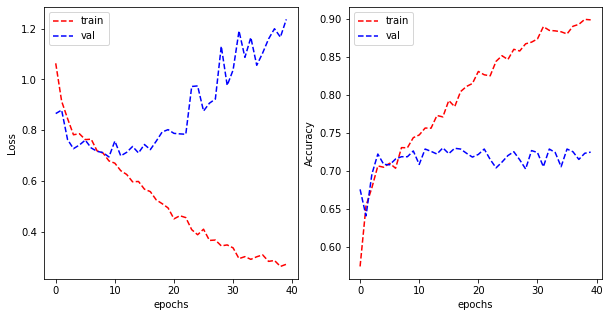

In [195]:
# first model
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

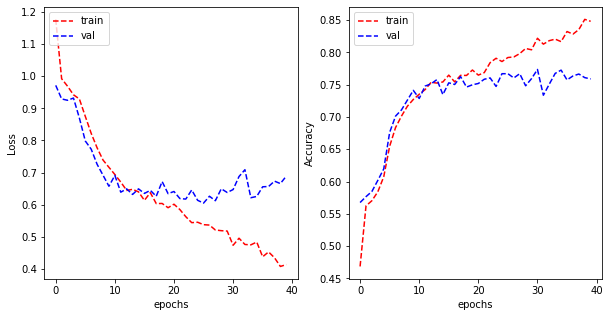

In [185]:
plot_learning_curve(history2.history['loss'], history2.history['val_loss'], 
                    history2.history['categorical_accuracy'], history2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Variations

In [30]:
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from keras import Sequential
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, Precision
from tensorflow.keras.utils import to_categorical

root = "Image_classification_data/multi-task"
def create_simple_cnn(no_classes):
    model = Sequential([
    Rescaling(1./255),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(no_classes, activation="softmax")
    ])
    model.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy(), Precision()])
    return model
def cnn_model(classes):
    images, labels = load_data(classes, root=root)
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

    x_train = np.array(x_train)
    x_test = np.array(x_test)
    no_classes = len(classes)
    y_train = to_categorical(label_encoder(y_train), no_classes)
    y_test = to_categorical(label_encoder(y_test), no_classes)

    model = create_simple_cnn(no_classes)
    model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
    return model


In [31]:
main = ["epithelial","fibroblast","inflammatory"]
three_main_model = cnn_model(["epithelial","fibroblast","inflammatory"])


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
213/213 [==============================] - ETA: 0s - loss: 0.8589 - categorical_accuracy: 0.6030 - precision_6: 0.7554WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f9809e36cb0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [33]:
three_main_model.save_weights("three_main.h5")

In [32]:
others_class = ["others","fibroblast","inflammatory"]
three_other_model = cnn_model(others_class)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
145/146 [============================>.] - ETA: 0s - loss: 1.0738 - categorical_accuracy: 0.4256 - precision_7: 0.5008WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f980f836320> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [34]:
three_other_model.save_weights("three_other.h5")